Trabajo practico de Vision Trasnformers

Por Carlos Villalobos

Consigna:
1. **Modificar los parametros:** Cambiar el tamaño de los parches, y la cantidad de dimensiones del embedding. Investigar y describir las ventajas y desventajas de tener más o menos parches/dimensiones.


2. **Implementar embedding posicional aprendido 1D:** Partiendo de ejemplo proporcionado (codificación sinusoidal en clase PositionalEncoding), implementar una clase PositionalEncodingLearned que utilice PyTorch y genere embebidos posicionales aprendidos. Graficar.


Configuración: Patch Size = 32, Embed Dim = 16
Número de parches: 784
Resolución espacial: 32x32 pixels
Parámetros totales: 12544

Configuración: Patch Size = 64, Embed Dim = 8
Número de parches: 196
Resolución espacial: 64x64 pixels
Parámetros totales: 1568

Configuración: Patch Size = 128, Embed Dim = 4
Número de parches: 49
Resolución espacial: 128x128 pixels
Parámetros totales: 196


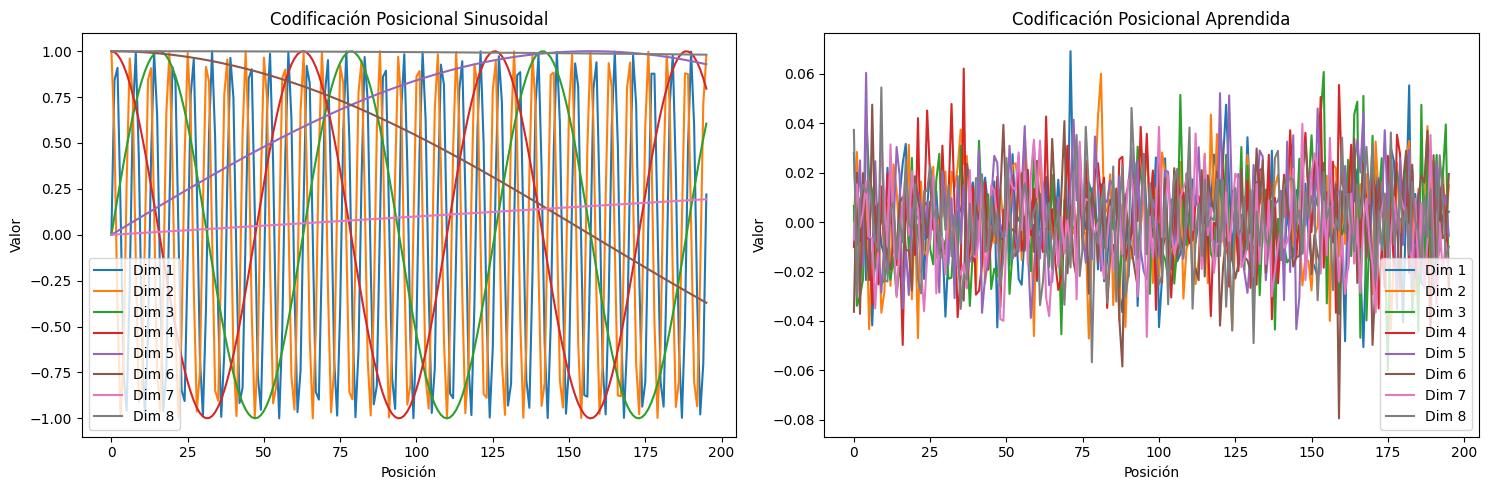

In [5]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import math

# Configuraciones a probar
configs = [
    {"patch_size": 32, "embed_dim": 16},
    {"patch_size": 64, "embed_dim": 8},
    {"patch_size": 128, "embed_dim": 4}
]

def analyze_config(img_size, patch_size, embed_dim):
    num_patches = (img_size // patch_size) ** 2
    total_params = num_patches * embed_dim
    return {
        "num_patches": num_patches,
        "total_params": total_params,
        "spatial_resolution": patch_size
    }

# Análisis de diferentes configuraciones
img_size = 900
for config in configs:
    analysis = analyze_config(img_size, config["patch_size"], config["embed_dim"])
    print(f"\nConfiguración: Patch Size = {config['patch_size']}, Embed Dim = {config['embed_dim']}")
    print(f"Número de parches: {analysis['num_patches']}")
    print(f"Resolución espacial: {analysis['spatial_resolution']}x{analysis['spatial_resolution']} pixels")
    print(f"Parámetros totales: {analysis['total_params']}")

# Clase PositionalEncoding original
class PositionalEncoding(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.register_buffer('pos_embedding', self.create_positional_encoding(num_patches, embed_dim))

    def create_positional_encoding(self, num_patches, embed_dim):
        position = torch.arange(num_patches, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        pos_encoding = torch.zeros(num_patches, embed_dim)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)  # Aplicar seno en dimensiones pares
        pos_encoding[:, 1::2] = torch.cos(position * div_term)  # Aplicar coseno en dimensiones impares
        return pos_encoding.unsqueeze(0)  # Añadir dimensión de batch

    def forward(self, x):
        return x + self.pos_embedding

# Implementación de la clase PositionalEncodingLearned
class PositionalEncodingLearned(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim) * 0.02)

    def forward(self, x):
        return x + self.pos_embedding

# Función para visualizar y comparar ambos encodings
def compare_positional_encodings(num_patches, embed_dim, device):
    # Inicializar ambos tipos de encoding
    learned_pe = PositionalEncodingLearned(num_patches, embed_dim).to(device)
    sinusoidal_pe = PositionalEncoding(num_patches, embed_dim).to(device)

    # Generar datos de ejemplo
    x = torch.zeros(1, num_patches, embed_dim).to(device)

    # Obtener embeddings
    learned_embeddings = learned_pe(x)
    sinusoidal_embeddings = sinusoidal_pe(x)

    # Visualizar
    plt.figure(figsize=(15, 5))

    # Sinusoidal
    plt.subplot(1, 2, 1)
    for i in range(embed_dim):
        plt.plot(sinusoidal_embeddings[0, :, i].detach().cpu().numpy(),
                label=f'Dim {i+1}')
    plt.title('Codificación Posicional Sinusoidal')
    plt.xlabel('Posición')
    plt.ylabel('Valor')
    plt.legend()

    # Learned
    plt.subplot(1, 2, 2)
    for i in range(embed_dim):
        plt.plot(learned_embeddings[0, :, i].detach().cpu().numpy(),
                label=f'Dim {i+1}')
    plt.title('Codificación Posicional Aprendida')
    plt.xlabel('Posición')
    plt.ylabel('Valor')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Probar con los parámetros originales
img_size = 900
patch_size = 64
embed_dim = 8
num_patches = (img_size // patch_size) ** 2
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

compare_positional_encodings(num_patches, embed_dim, device)

1. Al modificar el tamaño de los parches vemos que al bajarlo a 32, hay una resolución espacial mas alta, lo cual nos ayuda a obtener unos detalles mas finos. Dado que son mas parches esto eleva el costo computacional.
Al subirlo a 128 hay un menor costo computacional, pero se pierden detalles finos al tener una menor resolucion espacial.

Con dimensiones de embedding altas, en este caso de 16. Tenemos una mejor captura de características complejas. Pero se tienen que entrenar mas parámetros, y esto lleva a un mayor uso de memoria.`
Con dimensiones bajas, de 4. Se tienen menos parámetros, bajando la carga computacional. Pero se tiene una menor capacidad de representación.